# План

1. Построить простую нейросеть для теста
2. Построить нейросеть с архитектурой VGGNet-16
Для каждого из вариантов:
  1. Обучить на базовом датасете cifar
  2. Обучить на собраном датасете со статистическимми графиками распределений
3. Визуализировать процесс обучения
4. Научиться логировать процессы
5. Написать свой DataLoader [опционально]
6. Реализовать аугментацию данных
7. Сравнить на каких аугментациях модель обучилась классифицировать типы графиков распределений лучше всего
8. Проанализировать результаты и сделать выводы





# Код

## База

In [290]:
# избавляемся от полотна ошибок
import warnings
warnings.filterwarnings("ignore")

# основные библиотеки для построения моделей
import pandas as pd
import numpy as np
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms as T

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from tqdm import tqdm
from PIL import Image

# вспомогательные библиотеки
import os
import shutil
from random import shuffle

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

In [291]:
# обучение модели будет происходить на gpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')

## Аугментации

In [292]:
# отсечение части изображения до (224 * 0.5) х (224 * 0.5)
crop_transform = [T.Resize((224, 224)),  T.RandomCrop(224 * 0.5), T.ToTensor()]
# перспективное преобразование, случайный перспективный сдвиг на 100*s%
s = torch.rand(1)
perspective_transform = [T.Resize((224, 224)), T.RandomPerspective(distortion_scale=s), T.ToTensor()]
# поворот изображения на t градусов
t = torch.randint(0, 360, (1,)).item()
rotation_transform = [T.Resize((224, 224)), T.RandomRotation(t), T.ToTensor()]
# изменение свойств цвета изображения
# br = torch.randint(0, 100, (1,)).item() # яркость
br = 1
con = torch.randint(0, 100, (1,)).item() # контраст
sat = torch.randint(0, 100, (1,)).item() # насыщенность
hue = min(0.5, torch.rand(1).item()) # оттенок
color_transform = [T.Resize((224, 224)), T.ColorJitter(brightness=br, contrast=con, saturation=sat, hue=hue), T.ToTensor()]

# базовое преобразование
base_transforms = [T.Resize((224, 224)), T.ToTensor()]

## Создание dataset

### Распределение изображений по папкам

In [293]:
# изображения загружаю zip файлом, поэтому здесь распаковываю
!unzip '/content/graphs.zip'

Archive:  /content/graphs.zip
  inflating: geom_7.jpg              
  inflating: norm_7.jpg              
  inflating: norm_2.jpg              
  inflating: poisson_8.jpg           
  inflating: norm_9.jpg              
  inflating: uniform_2.jpg           
  inflating: poisson_7.jpg           
  inflating: geom_9.jpg              
  inflating: binom_0.jpg             
  inflating: chi2_3.jpg              
  inflating: expon_0.jpg             
  inflating: norm_5.jpg              
  inflating: expon_8.jpg             
  inflating: norm_0.jpg              
  inflating: poisson_6.jpg           
  inflating: chi2_7.jpg              
  inflating: chi2_6.jpg              
  inflating: geom_2.jpg              
  inflating: geom_3.jpg              
  inflating: binom_9.jpg             
  inflating: geom_8.jpg              
  inflating: binom_5.jpg             
  inflating: uniform_4.jpg           
  inflating: geom_6.jpg              
  inflating: norm_4.jpg              
  inflating: uniform

In [294]:
# создание папок под обучающие и тестовые данные
!mkdir '/content/graphs_classes'
!mkdir '/content/graphs_classes/train'
!mkdir '/content/graphs_classes/test'

mkdir: cannot create directory ‘/content/graphs_classes’: File exists
mkdir: cannot create directory ‘/content/graphs_classes/train’: File exists
mkdir: cannot create directory ‘/content/graphs_classes/test’: File exists


In [295]:
# пути под обучающие и тестовые данные
path_train = '/content/graphs_classes/train'
path_test = '/content/graphs_classes/test'

# метки для изображений
labels = {
    'binom': 1,
    'chi2': 2,
    'expon': 3,
    'geom': 4,
    'norm': 5,
    'poisson': 6,
    'uniform': 7
}

# перекладываем изображения в нужную папку
images = []
for image in os.listdir('./'):
    if image.split('_')[0] in labels:
        images.append(image)
# перемешиваем, чтобы не было смещения по распределению классов
shuffle(images)

In [296]:
# 70% на обучение, 30% на тест
for i in range(len(images)):
    image = images[i]
    print(f'/content/{image}', f'{path_train}/{image}')
    if i < len(images) * 0.7:
        shutil.move(f'/content/{image}', f'{path_train}/{image}')
    else:
        shutil.move(f'/content/{image}', f'{path_test}/{image}')

/content/geom_2.jpg /content/graphs_classes/train/geom_2.jpg
/content/norm_3.jpg /content/graphs_classes/train/norm_3.jpg
/content/poisson_6.jpg /content/graphs_classes/train/poisson_6.jpg
/content/binom_5.jpg /content/graphs_classes/train/binom_5.jpg
/content/expon_5.jpg /content/graphs_classes/train/expon_5.jpg
/content/geom_4.jpg /content/graphs_classes/train/geom_4.jpg
/content/expon_4.jpg /content/graphs_classes/train/expon_4.jpg
/content/binom_0.jpg /content/graphs_classes/train/binom_0.jpg
/content/uniform_8.jpg /content/graphs_classes/train/uniform_8.jpg
/content/expon_9.jpg /content/graphs_classes/train/expon_9.jpg
/content/poisson_5.jpg /content/graphs_classes/train/poisson_5.jpg
/content/chi2_8.jpg /content/graphs_classes/train/chi2_8.jpg
/content/expon_3.jpg /content/graphs_classes/train/expon_3.jpg
/content/expon_8.jpg /content/graphs_classes/train/expon_8.jpg
/content/norm_4.jpg /content/graphs_classes/train/norm_4.jpg
/content/chi2_7.jpg /content/graphs_classes/train/chi

### Создание dataset

In [297]:
# класс собственного dataset
class dataset_statistic(torch.utils.data.Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.files[index])
        image = Image.open(img_path)
        label = labels[img_path.split('/')[-1].split('_')[0]]

        if self.transforms:
            for t in self.transforms:
                image = t(image)
        return (image, torch.tensor(label))

In [298]:
# функция для отрисовки изображения
def show_image(data):
    img = data[0]
    label = data[1].item()
    print(label)
    plt.imshow(img.permute(1, 2, 0))

## dataloaders с различными преобразованиями

### Тестовые данные фиксированны

In [299]:
test_data = dataset_statistic(path_test, transforms=base_transforms)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

### Отсечение части изображения

In [300]:
train_crop_data = dataset_statistic(path_train, transforms=crop_transform)
train_crop_loader = torch.utils.data.DataLoader(train_crop_data, batch_size=32, shuffle=True)

<class 'tuple'> <class 'torch.Tensor'> <class 'torch.Tensor'>
5


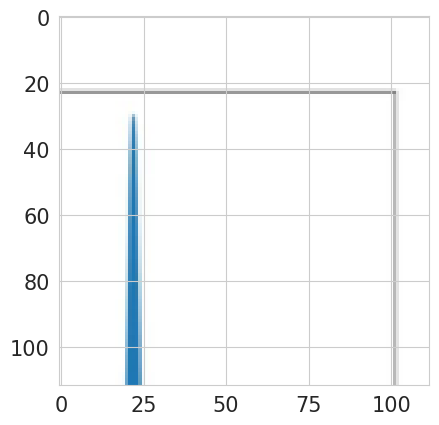

In [301]:
ind = 9
data = train_crop_data[ind]
print(type(data), type(data[0]), type(data[1]))
show_image(data)

### Перспективное преобразование

In [302]:
train_perspective_data = dataset_statistic(path_train, transforms=perspective_transform)
train_perspective_loader = torch.utils.data.DataLoader(train_perspective_data, batch_size=32, shuffle=True)

<class 'tuple'> <class 'torch.Tensor'> <class 'torch.Tensor'>
5


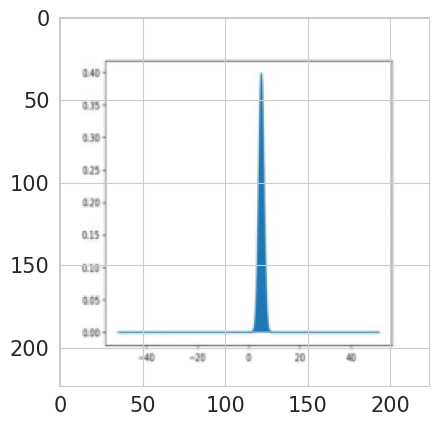

In [303]:
ind = 9
data = train_perspective_data[ind]
print(type(data), type(data[0]), type(data[1]))
show_image(data)

### Поворот изображения

In [304]:
train_rotate_data = dataset_statistic(path_train, transforms=rotation_transform)
train_rotate_loader = torch.utils.data.DataLoader(train_rotate_data, batch_size=32, shuffle=True)

<class 'tuple'> <class 'torch.Tensor'> <class 'torch.Tensor'>
5


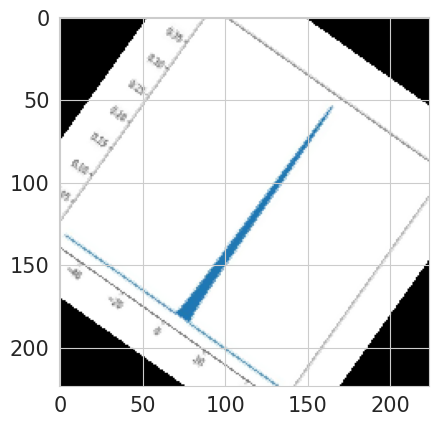

In [305]:
ind = 9
data = train_rotate_data[ind]
print(type(data), type(data[0]), type(data[1]))
show_image(data)

### Изменение цвета изображения

In [306]:
train_color_data = dataset_statistic(path_train, transforms=color_transform)
train_color_loader = torch.utils.data.DataLoader(train_color_data, batch_size=32, shuffle=True)

3


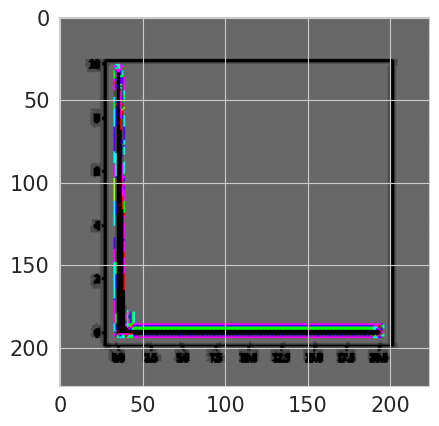

In [307]:
ind = 8
data = train_color_data[ind]
show_image(data)

### cifar dataset

In [308]:
# преобразования над входными изображениями
transform = T.Compose({
    T.ToTensor(),
    T.Resize((8, 8))
})
# загружаем тестовый датасет
train_data = torchvision.datasets.CIFAR10(
    './cifar', train=True, download=True, transform=transform
)
# загружаем валидационный датасет
val_data = torchvision.datasets.CIFAR10(
    './cifar', train=False, download=True, transform=transform
)
# даталоадер для обучения
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=32, shuffle=True
)
# даталоадер для валидации
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=32, shuffle=False
)

100%|██████████| 170M/170M [00:03<00:00, 50.8MB/s]


Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


## Модели

### Основная модель

In [25]:
class LokiNet(nn.Module):
    def __init__(self, img_channels=3, num_classes=10):
        super().__init__()
        # обычно эту часть называют «тушкой модели»
        self.encoder = nn.Sequential(
            # первый свёрточный слой
            nn.Conv2d(in_channels=img_channels, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # экскурс: stride - шаг, с которым прикладываем ядро свёртки
            # паддинг - размер доп обрамления (чтобы учитывать края изображения при свёртке)
            # функция активации
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            # ещё одна техника, фактически проходимя матричкой 2x2 и берём максимум, делаем с шагом stride
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        # обычно называют «головой», тк это полносвязные сети, которые могут уловить больше необходимой информации
        self.head = nn.Sequential(
            # полносвязный слой
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(),
            # dropout механизм «выкидывания» нейронов из сетки с вероятностью p
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=num_classes)
        )

    def forward(self, x):
        out = self.encoder(x)
        # растягиваем матричку в вектор
        out = nn.Flatten()(out)
        out = self.head(out)
        return out

### Тестовая модель

In [26]:
class smallNet(nn.Module):
    def __init__(self, img_channels=3, num_classes=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=img_channels, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
        )
        self.head = nn.Sequential(
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=num_classes),
        )

    def forward(self, x):
        # print(x.shape)
        out = self.encoder(x)
        # print(out.shape)
        out = nn.Flatten()(out)
        # print(out.shape)
        out = self.head(out)
        return out

## Визуализация

In [27]:
def plot_logs(train_accuracies, test_accuracies, train_losses, test_losses):
  clear_output()
  fig, axs = plt.subplots(1, 2, figsize=(13, 4))

  axs[1].plot(train_accuracies, label='train')
  points = np.array(test_accuracies)
  axs[1].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
  axs[1].set_ylabel('accuracy')

  axs[0].plot(train_losses, label='train')
  points = np.array(test_losses)
  axs[0].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
  axs[0].set_ylabel('loss')

  for ax in axs:
      ax.set_xlabel('step')
      ax.legend()

  plt.show()

## Обучение и тест

Нейросети обучают эпохами, эпоха -- это один цикл обучения модели на массиве данных

In [28]:
def train_epoch(model, criterion, train_loader, optimizer):
    # режим работы модели, нужен хотя бы для dropout, тк в трейне нейроны можно выкидывать, а при предсказании трогать ничего не надо
    model.train()

    accuracy_log, loss_log = [], []
    # x_batch: [32, 3, 224, 224]
    # y_batch: [32]
    for num_batch, (x_batch, y_batch) in enumerate(train_loader):
        # скидываем на gpu
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # обнуление градиента, тк он копится при новом взятии производной
        optimizer.zero_grad()

        # предсказываем вероятности
        logits = model(x_batch)

        # считаем лосс
        loss = criterion(logits, y_batch)
        # находим производную
        loss.backward()
        # делаем шаг градиентного спуска
        optimizer.step()

        # предсказания
        y_pred = torch.max(logits, dim=1)[1].cpu().detach().numpy()
        y_true = y_batch.cpu().detach().numpy()

        # сохраняем статистику
        accuracy_log.append(np.mean(y_pred == y_true))
        loss_log.append(loss.item())

    return accuracy_log, loss_log

In [29]:
def test(model, criterion, test_loader):
    # режим вычислний
    model.eval()

    accuracy_log, loss_log = [], []
    # x_batch: [32, 3, 224, 224]
    # y_batch: [32]
    for num_batch, (x_batch, y_batch) in enumerate(test_loader):
        # скидываем на gpu
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # градиент нам тут считать не нужно, не используем при тесте
        with torch.no_grad():
            # предсказываем вероятности
            logits = model(x_batch)
            # считаем лосс
            loss = criterion(logits, y_batch)

        # предсказания
        y_pred = torch.max(logits, dim=1)[1].cpu().detach().numpy()
        y_true = y_batch.cpu().detach().numpy()

        # сохраняем статистику
        accuracy_log.append(np.mean(y_pred == y_true))
        loss_log.append(loss.item())

    return accuracy_log, loss_log

In [30]:
def train(model, criterion, train_loader, val_loader, optimizer, num_epoches, batch_size):
    # сохраняем логи для визуализации
    train_accuracy_log, train_loss_log = [], []
    test_accuracy_log, test_loss_log = [], []

    for epoch in range(num_epoches):
        train_accuracy, train_loss = train_epoch(model, criterion, train_loader, optimizer)
        test_accuracy, test_loss = test(model, criterion, val_loader)

        train_accuracy_log.extend(train_accuracy)
        train_loss_log.extend(train_loss)

        steps = train_loader.dataset.__len__() / batch_size

        test_accuracy_log.append((steps * (epoch + 1), np.mean(test_accuracy)))
        test_loss_log.append((steps * (epoch + 1), np.mean(test_loss)))

        clear_output()
        plot_logs(train_accuracy_log, test_accuracy_log, train_loss_log, test_loss_log)

    info = {
        'train_acc': np.mean(train_accuracy_log),
        'test_acc': test_accuracy_log[-1],
        'train_loss': np.mean(test_loss_log),
        'test_loss': test_loss_log[-1]
        }

    return info

## Тестирование модели

In [36]:
model = LokiNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

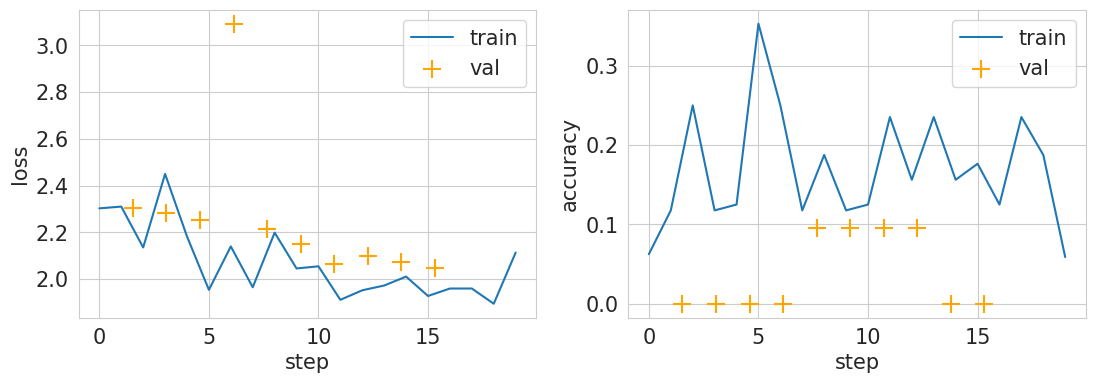

In [37]:
results = train(model, criterion, train_loader, val_loader, optimizer, num_epoches=10, batch_size=32)